In [12]:
## 🛠️ Part 1: Setup, Installation, and Mounting

# --- 1. INSTALLING LIBRARIES ---
print("Installing required libraries...")
# Include safetensors to correctly load model.safetensors
!pip install --upgrade transformers accelerate datasets scikit-learn sentencepiece safetensors -q

# --- 2. IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
# Import all necessary components
from transformers import AutoTokenizer, DebertaV2Model, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from safetensors.torch import load_file as safe_load # For model.safetensors loading

# --- 3. CONFIGURATION & PATHS (Verified) ---
RNG = 42
BASE_DRIVE_PATH = '/content/drive/MyDrive/THESIS 47'
# 💥 CORRECT PATH: checkpoint is in 'Saved Datasets'
GDRIVE_MODEL_PATH = os.path.join(BASE_DRIVE_PATH, 'Saved Datasets', 'checkpoint-9740')
GDRIVE_DATASET_PATH = os.path.join(BASE_DRIVE_PATH, 'Saved Datasets', 'Non English reviews deleted All_Language_Data - Copy.csv') # Adjusted for safety
MODEL_CHECKPOINT = "microsoft/deberta-v3-base"
N_CLASSES = 2
class_names = ['Negative', 'Positive']
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 4. MOUNT GOOGLE DRIVE ---
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# --- 5. INITIAL CHECK ---
if os.path.exists(GDRIVE_MODEL_PATH) and os.path.exists(GDRIVE_DATASET_PATH):
    print("\n✅ Drive mount successful and required paths verified.")
else:
    print("\n❌ CRITICAL ERROR: One or more paths not found.")
    raise FileNotFoundError(f"Please check paths. Model: {GDRIVE_MODEL_PATH}, Data: {GDRIVE_DATASET_PATH}")

print("\n--- Part 1: Setup and Mounting Complete ---")

Installing required libraries...

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Drive mount successful and required paths verified.

--- Part 1: Setup and Mounting Complete ---


In [13]:
## 🛠️ Part 2: Data Preprocessing and Model Class Definitions (Patched with from_pretrained)

# --- 1. DATA LOADING AND PREPROCESSING ---
print("\n--- Rerunning Data Preprocessing and Tokenization ---")
raw_df = pd.read_csv(GDRIVE_DATASET_PATH)
df = raw_df.dropna(subset=['reviewText', 'sentiment_label']).copy()
df['label'] = df['sentiment_label'].astype(int)
df['combined_text'] = df['reviewText']

# Stratified Split
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=RNG, stratify=df['label'])
train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)
y_train = train_df['label'].values.astype(int)

# Calculate Class Weights
classes_in_y = np.unique(y_train)
class_weights_np = compute_class_weight(class_weight="balanced", classes=classes_in_y, y=y_train)
class_weights = torch.tensor(class_weights_np, dtype=torch.float)

# Tokenizer and HF Dataset Prep (Assumes tokenizer is loaded in Part 1)
def build_features(split_df):
    out = {}
    out['combined_text'] = split_df['combined_text'].tolist()
    out['label'] = split_df['label'].astype(int).tolist()
    return out

train_feats = build_features(train_df)
test_feats  = build_features(test_df)

raw_datasets = DatasetDict({'train': Dataset.from_dict(train_feats), 'test':  Dataset.from_dict(test_feats)})
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_fn(examples):
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["combined_text"])
tokenized_datasets.set_format("torch")
print("✅ Data loading and tokenization complete.")


# --- 3. MODEL ARCHITECTURE AND CUSTOM TRAINER CLASSES (WITH FIX) ---

class TextOnlyClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.deberta = DebertaV2Model.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.deberta.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels=None):
        deberta_output = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(deberta_output.last_hidden_state[:, 0])
        logits = self.classifier(pooled_output)
        return (None, logits)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *args, **kwargs):
        """Robust custom method to load model weights saved by Hugging Face Trainer (Handles safetensors)."""
        num_labels = kwargs.pop('num_labels', 2)
        model = cls(num_labels=num_labels)

        # Determine the file to load: model.safetensors is guaranteed to exist.
        safetensors_path = os.path.join(pretrained_model_name_or_path, "model.safetensors")

        if os.path.exists(safetensors_path):
            state_dict = safe_load(safetensors_path) # Use safetensors load
        else:
            # Fallback for old PyTorch binary format
            bin_path = os.path.join(pretrained_model_name_or_path, "pytorch_model.bin")
            if os.path.exists(bin_path):
                 state_dict = torch.load(bin_path, map_location="cpu")
            else:
                 raise FileNotFoundError(f"Model weight file missing! Expected model.safetensors or pytorch_model.bin in {pretrained_model_name_or_path}")

        # Load the state dictionary into the custom model
        model.load_state_dict(state_dict, strict=True)
        return model

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], labels=labels)
        logits = outputs[1]
        weights = class_weights.to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, self.model.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

class TextOnlyDataCollator:
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        batch['labels'] = torch.tensor([f['label'] for f in features], dtype=torch.long)
        return batch

def compute_metrics(pred):
    labels = pred.label_ids
    predictions = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
    preds = predictions.argmax(-1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec}

print("\n--- Part 2: Data & Model Classes Defined ---")


--- Rerunning Data Preprocessing and Tokenization ---


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/155840 [00:00<?, ? examples/s]

Map:   0%|          | 0/38961 [00:00<?, ? examples/s]

✅ Data loading and tokenization complete.

--- Part 2: Data & Model Classes Defined ---



Loading weights from checkpoint: /content/drive/MyDrive/THESIS 47/Saved Datasets/checkpoint-9740...


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


✅ Model weights loaded successfully from Google Drive.

--- Final Evaluation on Test Set ---
Generating predictions...



--- Classification Report (BINARY DeBERTa - Checkpoint 9740) ---
              precision    recall  f1-score   support

    Negative     0.8951    0.9176    0.9062     19408
    Positive     0.9161    0.8933    0.9046     19553

    accuracy                         0.9054     38961
   macro avg     0.9056    0.9055    0.9054     38961
weighted avg     0.9057    0.9054    0.9054     38961



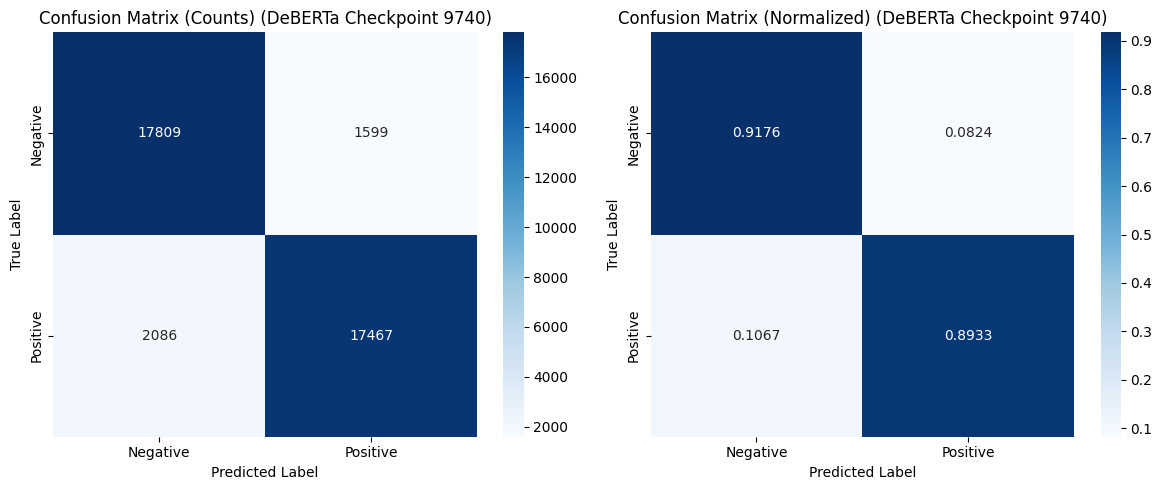

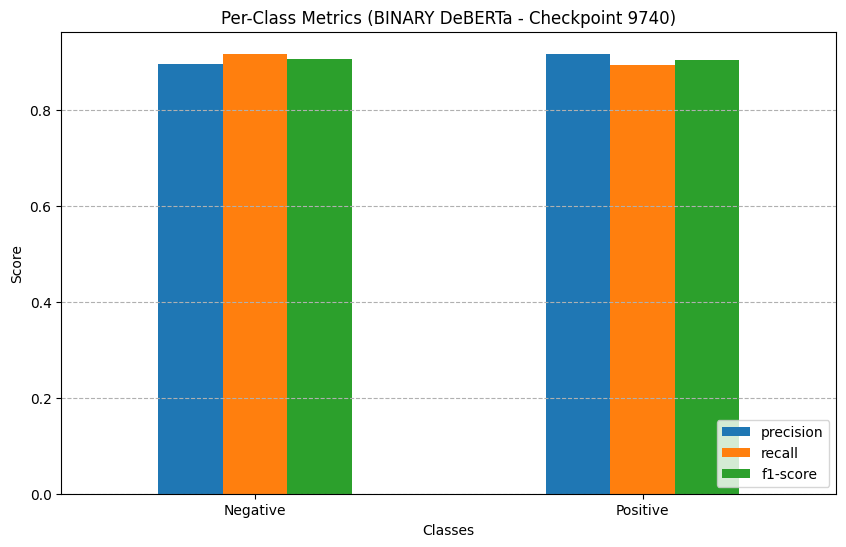


--- Part 3: Evaluation Complete ---


In [14]:
## 🛠️ Part 3: Model Loading and Evaluation (Execution)

# --- 1. INITIALIZE TRAINER FOR EVALUATION ---
eval_args = TrainingArguments(
    output_dir="./eval_output",
    per_device_eval_batch_size=16,
    report_to="none",
    fp16=True if torch.cuda.is_available() else False,
)

# Initialize the model structure
model_for_eval = TextOnlyClassifier(num_labels=N_CLASSES)

trainer = WeightedTrainer(
    model=model_for_eval,
    args=eval_args,
    eval_dataset=tokenized_datasets["test"],
    data_collator=TextOnlyDataCollator(tokenizer),
    compute_metrics=compute_metrics,
)

# --- 2. LOAD SAVED CHECKPOINT WEIGHTS ---
print(f"\nLoading weights from checkpoint: {GDRIVE_MODEL_PATH}...")
try:
    # This will now correctly use the patched from_pretrained method
    model_for_eval = TextOnlyClassifier.from_pretrained(GDRIVE_MODEL_PATH, num_labels=N_CLASSES).to(DEVICE)
    trainer.model = model_for_eval
    print("✅ Model weights loaded successfully from Google Drive.")
except Exception as e:
    print(f"❌ ERROR: Failed to load model weights. Ensure the path is correct: {GDRIVE_MODEL_PATH}. Error: {e}")
    raise

# --- 3. RUN EVALUATION ---
print("\n--- Final Evaluation on Test Set ---")
print("Generating predictions...")

preds_output = trainer.predict(tokenized_datasets["test"])

logits = preds_output.predictions[0] if isinstance(preds_output.predictions, tuple) else preds_output.predictions
pred_labels = np.argmax(logits, axis=-1)
true_labels = np.array(tokenized_datasets["test"]["label"])

# --- 4. PRINT CLASSIFICATION REPORT ---
print("\n--- Classification Report (BINARY DeBERTa - Checkpoint 9740) ---")
report_text = classification_report(true_labels, pred_labels, target_names=class_names, digits=4, zero_division=0)
print(report_text)

# --- 5. VISUALIZATIONS ---

# CONFUSION MATRIX
cm = confusion_matrix(true_labels, pred_labels)
row_sums = cm.sum(axis=1, keepdims=True); row_sums[row_sums == 0] = 1
cm_norm = cm.astype('float') / row_sums

plt.figure(figsize=(12, 5))

# Counts (Integers)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Counts) (DeBERTa Checkpoint 9740)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Normalized (Floats with 4 decimals)
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized) (DeBERTa Checkpoint 9740)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# PER-CLASS BAR CHART
report_dict = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]

plt.figure(figsize=(10, 6))
report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', ax=plt.gca())
plt.title('Per-Class Metrics (BINARY DeBERTa - Checkpoint 9740)')
plt.xlabel('Classes'); plt.ylabel('Score')
plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--'); plt.legend(loc='lower right')
plt.show()


print("\n--- Part 3: Evaluation Complete ---")